# MiniLearn: A PyTorch Learner Framework with Callback System

This notebook demonstrates **MiniLearn**, a custom deep learning training framework built on top of PyTorch. Inspired by fastai and Lightning, it enables rapid experimentation while preserving flexibility. Key features include a modular callback system, exception-based control flow, automatic device management, early stopping, model checkpointing, and integrated metrics tracking via torcheval.

## Motivation

While PyTorch offers flexibility, training deep learning models often involves repetitive code and limited iteration speed. MiniLearn abstracts the training loop to reduce redundancy while remaining lightweight, easy to understand, and fully flexible.

In [1]:
import torch
import torch.nn.functional as F
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset
import matplotlib.pyplot as plt


In [2]:
from minilearn.learner import Learner
from minilearn.callbacks import DeviceCB, ProgressCB, EarlyStoppingCB, CheckpointsCB
from minilearn.metrics import MetricsCB
from minilearn.lr_finder import LRFinderCB
from minilearn.utils import to_device
from minilearn.hooks import Hook, Hooks, append_stats

## Example: Training on FashionMNIST

In this example, we demonstrate how to use the MiniLearn framework to train a simple neural network on the FashionMNIST dataset.

We prepare our dataset, setup the dataloaders, and define the model first.

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

In [4]:
name = "fashion_mnist"
dsd = load_dataset(name)

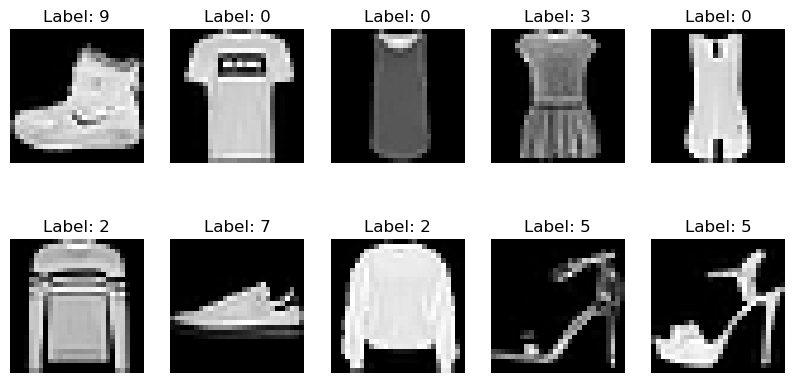

In [5]:
num_images = 10
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    item = dsd['train'][i]
    ax.imshow(item['image'], cmap='gray')
    ax.set_title(f"Label: {item['label']}")
    ax.axis("off")

In [6]:
mytransforms = transforms.Compose([transforms.ToTensor()])

In [7]:
class FashionMnist(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
train_dataset = FashionMnist(dataset = dsd['train'], transform = mytransforms)
valid_dataset = FashionMnist(dataset = dsd['test'], transform = mytransforms)

In [9]:
train_dataset_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True,num_workers=0)
valid_dataset_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=True,num_workers=0)

In [10]:
def get_model():
    m,nh = 28*28,50
    
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(m,nh), 
    nn.ReLU(), 
    nn.Linear(nh,10)
    )
    return  model
model = get_model()

We create a set of the modular callbacks we want to use during training. These include:
 - `DeviceCB` for GPU support
 - `ProgressCB` for progress bars and **and optional loss plotting after training**
 - `MetricsCB` for tracking accuracy and loss
 - `EarlyStoppingCB` to end training early when our model stops imporiving 
 - `CheckpointsCB` to save the best model

In [11]:
cbs = [
    DeviceCB(),
    ProgressCB(plot=True),
    MetricsCB(MulticlassAccuracy()),
    EarlyStoppingCB(monitor='MulticlassAccuracy', mode='max'),
    CheckpointsCB(monitor='MulticlassAccuracy', mode='max', cooldown = 5)
]

Before training, we can use the `LRFinderCB` callback to find an optimal learning rate.

By passing it directly into the `fit()` method, it is temporarily added to the active list of callbacks for that training run. Once the learning rate search is complete, the callback is removed—ensuring it doesn't interfere with the main training process.

Train Epoch 1/1:  56%|█████████████████████████████                       | 33/59 [00:07<00:05,  4.81it/s, loss=2.2919]

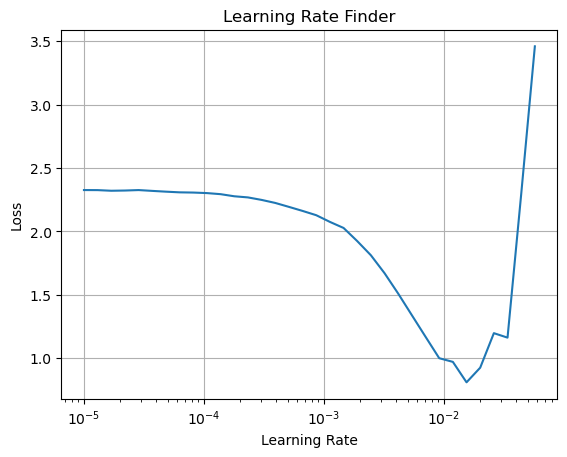

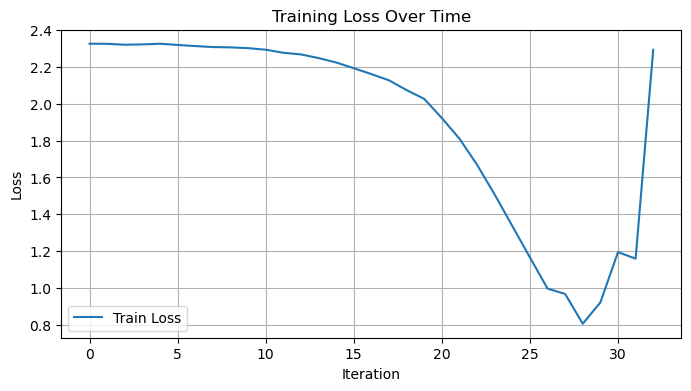

[CheckpointsCB] No best model was saved during training.


In [12]:
learn = Learner(get_model(), train_dataset_loader,valid_dataset_loader , F.cross_entropy,cbs = cbs, lr=1e-5, opt_func = optim.Adam)
learn.fit(cbs = [LRFinderCB()])

After running `LRFinderCB`, a plot of loss versus learning rate is generated. We use this to select a learning rate of `1e-2`, which appears just before the loss begins to spike. Choosing a learning rate near this point often results in faster and more stable convergence during training.

Since the LR finder modifies model weights during the search, we restore the original model state before actual training. This is done by passing `reset=True` and `reset_exact=True` to the `fit()` method. These reload the model’s initial weights, ensuring that training begins from the same starting point as before the LR search.

Since we're using `EarlyStoppingCB`, we set the number of epochs to 100. The callback will automatically stop training once the monitored metric (in this case, Accuracy) stops improving for a defined number of epochs.

Train Epoch 1/100: 100%|██████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.01it/s, loss=0.4635]


{'MulticlassAccuracy': '0.7378', 'loss': '0.7253', 'epoch': 1, 'train': 'train'}


Valid Epoch 1/100: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s, loss=0.5121]


{'MulticlassAccuracy': '0.8172', 'loss': '0.5127', 'epoch': 1, 'train': 'eval'}


Train Epoch 2/100: 100%|██████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.35it/s, loss=0.4056]


{'MulticlassAccuracy': '0.8422', 'loss': '0.4492', 'epoch': 2, 'train': 'train'}


Valid Epoch 2/100: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.39it/s, loss=0.4539]


{'MulticlassAccuracy': '0.8417', 'loss': '0.4565', 'epoch': 2, 'train': 'eval'}


Train Epoch 3/100: 100%|██████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.27it/s, loss=0.4313]


{'MulticlassAccuracy': '0.8587', 'loss': '0.4046', 'epoch': 3, 'train': 'train'}


Valid Epoch 3/100: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.66it/s, loss=0.4669]


{'MulticlassAccuracy': '0.8488', 'loss': '0.4337', 'epoch': 3, 'train': 'eval'}


Train Epoch 4/100: 100%|██████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.16it/s, loss=0.4118]


{'MulticlassAccuracy': '0.8662', 'loss': '0.3822', 'epoch': 4, 'train': 'train'}


Valid Epoch 4/100: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s, loss=0.4425]


{'MulticlassAccuracy': '0.8398', 'loss': '0.4480', 'epoch': 4, 'train': 'eval'}
No improvement in 'MulticlassAccuracy' for 1 epoch(s)...


Train Epoch 5/100: 100%|██████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.09it/s, loss=0.3294]


{'MulticlassAccuracy': '0.8709', 'loss': '0.3643', 'epoch': 5, 'train': 'train'}


Valid Epoch 5/100: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.84it/s, loss=0.4367]


{'MulticlassAccuracy': '0.8510', 'loss': '0.4204', 'epoch': 5, 'train': 'eval'}


Train Epoch 6/100: 100%|██████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.28it/s, loss=0.3305]


{'MulticlassAccuracy': '0.8778', 'loss': '0.3442', 'epoch': 6, 'train': 'train'}


Valid Epoch 6/100: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.39it/s, loss=0.3972]


{'MulticlassAccuracy': '0.8607', 'loss': '0.3974', 'epoch': 6, 'train': 'eval'}


Train Epoch 7/100: 100%|██████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.14it/s, loss=0.3611]


{'MulticlassAccuracy': '0.8802', 'loss': '0.3345', 'epoch': 7, 'train': 'train'}


Valid Epoch 7/100: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.33it/s, loss=0.4062]


{'MulticlassAccuracy': '0.8649', 'loss': '0.3822', 'epoch': 7, 'train': 'eval'}


Train Epoch 8/100: 100%|██████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.19it/s, loss=0.3938]


{'MulticlassAccuracy': '0.8819', 'loss': '0.3296', 'epoch': 8, 'train': 'train'}


Valid Epoch 8/100: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.40it/s, loss=0.3811]


{'MulticlassAccuracy': '0.8682', 'loss': '0.3761', 'epoch': 8, 'train': 'eval'}


Train Epoch 9/100: 100%|██████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.29it/s, loss=0.3063]


{'MulticlassAccuracy': '0.8871', 'loss': '0.3137', 'epoch': 9, 'train': 'train'}


Valid Epoch 9/100: 100%|██████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.80it/s, loss=0.4423]


{'MulticlassAccuracy': '0.8710', 'loss': '0.3717', 'epoch': 9, 'train': 'eval'}


Train Epoch 10/100: 100%|█████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.13it/s, loss=0.2999]


{'MulticlassAccuracy': '0.8880', 'loss': '0.3090', 'epoch': 10, 'train': 'train'}


Valid Epoch 10/100: 100%|█████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.29it/s, loss=0.3632]


{'MulticlassAccuracy': '0.8707', 'loss': '0.3682', 'epoch': 10, 'train': 'eval'}
No improvement in 'MulticlassAccuracy' for 1 epoch(s)...


Train Epoch 11/100: 100%|█████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.34it/s, loss=0.3320]


{'MulticlassAccuracy': '0.8913', 'loss': '0.2973', 'epoch': 11, 'train': 'train'}


Valid Epoch 11/100: 100%|█████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.95it/s, loss=0.2822]


{'MulticlassAccuracy': '0.8768', 'loss': '0.3602', 'epoch': 11, 'train': 'eval'}


Train Epoch 12/100: 100%|█████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.28it/s, loss=0.2704]


{'MulticlassAccuracy': '0.8935', 'loss': '0.2924', 'epoch': 12, 'train': 'train'}


Valid Epoch 12/100: 100%|█████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.47it/s, loss=0.3751]


{'MulticlassAccuracy': '0.8555', 'loss': '0.3994', 'epoch': 12, 'train': 'eval'}
No improvement in 'MulticlassAccuracy' for 1 epoch(s)...


Train Epoch 13/100: 100%|█████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.12it/s, loss=0.2428]


{'MulticlassAccuracy': '0.8944', 'loss': '0.2882', 'epoch': 13, 'train': 'train'}


Valid Epoch 13/100: 100%|█████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.86it/s, loss=0.4111]


{'MulticlassAccuracy': '0.8682', 'loss': '0.3773', 'epoch': 13, 'train': 'eval'}
No improvement in 'MulticlassAccuracy' for 2 epoch(s)...


Train Epoch 14/100: 100%|█████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.10it/s, loss=0.2619]


{'MulticlassAccuracy': '0.8938', 'loss': '0.2898', 'epoch': 14, 'train': 'train'}


Valid Epoch 14/100: 100%|█████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.53it/s, loss=0.3749]


{'MulticlassAccuracy': '0.8754', 'loss': '0.3595', 'epoch': 14, 'train': 'eval'}
No improvement in 'MulticlassAccuracy' for 3 epoch(s)...
Early stopping at epoch 14
Restored best model weights.
Best 'MulticlassAccuracy': 0.877 at epoch 11


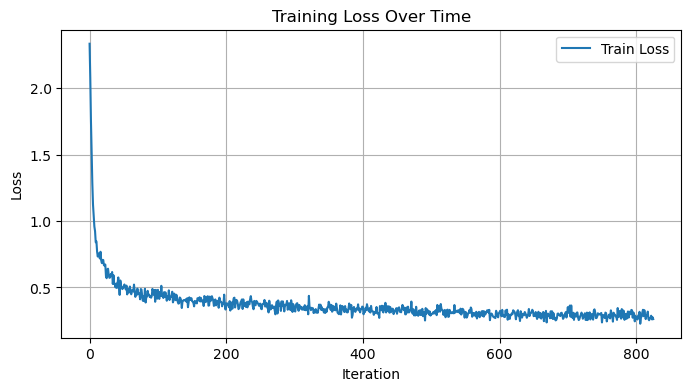

[CheckpointsCB] Best model saved to: C:\Users\luke6\Projects\Learner Framework\checkpoints\sequential\best\best_model.pth
[CheckpointsCB] Metric: 'MulticlassAccuracy' = 0.8768 (epoch 11)


In [13]:
learn.fit(100,train=True, valid=True, lr=1e-2, reset = True, reset_exact = True)

Training successfully converged with early stopping. `CheckpointsCB` automatically saves the best-performing model (based on the specifid metric) during training to the specified directory.

## Optional: Using hooks for Activation Stats

This section demonstrates how to use MiniLearn's built in hook system to insepct activation statistics during the forward pass.

Hooks allow you to monitor specific layers of a model during training or infrence to monitor values such as the mean, standard deviation, or histogram of activations. This can be useful in diagnosing internal issues that are not easily detected. In this example, we attach hooks to selected layers and track statistics during a forward pass over the data.

In [14]:
cbs = [ 
    DeviceCB(),
    MetricsCB(MulticlassAccuracy()), 
    ProgressCB(plot=True)
]

In [15]:
model = get_model()

Train Epoch 1/1: 100%|████████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.14it/s, loss=2.2749]


{'MulticlassAccuracy': '0.1043', 'loss': '2.2952', 'epoch': 1, 'train': 'train'}


Valid Epoch 1/1: 100%|████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.50it/s, loss=2.2685]


{'MulticlassAccuracy': '0.1116', 'loss': '2.2703', 'epoch': 1, 'train': 'eval'}


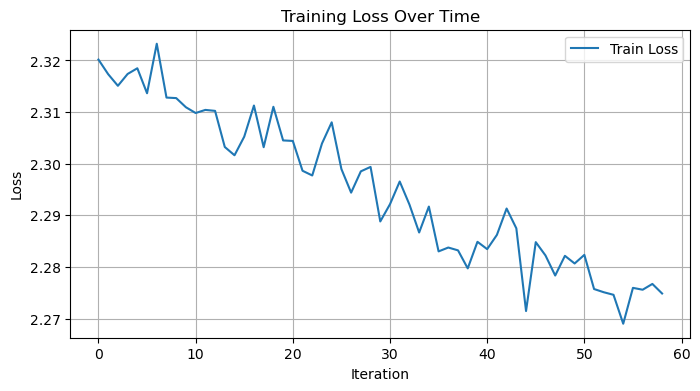

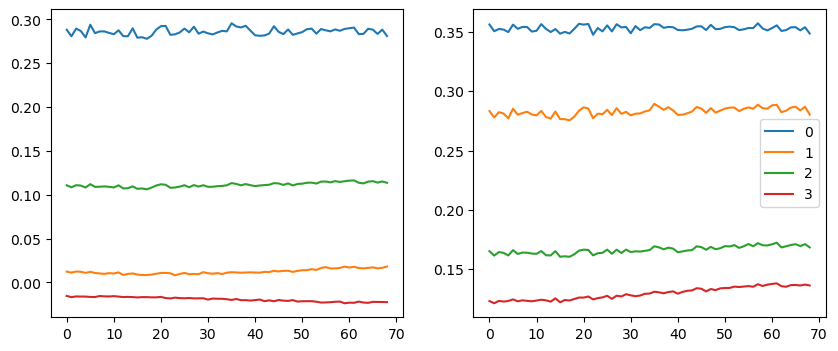

In [16]:
with Hooks(model, append_stats) as hooks:
    hooks_learner = Learner(model, train_dataset_loader,valid_dataset_loader , F.cross_entropy,cbs = cbs, lr=1e-5, opt_func = optim.Adam)
    hooks_learner.fit()
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: 
            axs[i].plot(h.stats[i])
    plt.legend(range(len(hooks)))
    

The activation statistic across the models layers remain stable throughout the forward pass, with no sudden spikes in the means or standard deviations. The indicates a healthy network. If there were issues like vanishing or exploding activations, we would expect to see sharp jumps or erratic behavior. 

Through the use of hooks with MiniLearn, we gain an intuitive way to monitor internal model behavior and the ability to catch issues early during experimentation.

## Conclusion

MiniLearn provides a clean, modular framework for training deep learning models with PyTorch. With support for callbacks, early stopping, checkpointing, learning rate finding, and hook-based diagnostics, it allows for efficient experimentation while remaining lightweight and flexible.